# Molecule selectivity prediction for serine protease inhibitors. #

## Simon Rüdisser and Nikolas Fechner ##
### Novartis Institutes for Biomedical Research, Novartis Campus, 4002 Basel, Switzerland ###

## Random forest classifier. ##

<http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>

A random forest classifier has been trained on molecule morgan2 fingerprints and $IC_{50}$ data (from ChEMBL) for the three serine proteases F10, trypsin and thrombin both by building a single multi-output model and by building three single output (common approach) models.
Estimator performance is evaluated by cross-validation, $\textit{i.e.}$ by dividing the data into training and test data sets.

The classifier has been trained as single label and multi label classifier:

- single output (label) classification (active or inactive on $\textit{e.g.}$ F10)
- multi output (label) classification (active or inactive on F10, trypsin, thrombin)


## Cross-validation on literature clusters and by random partitioning.

Splitting into test and training data sets has been based on literature source and by random partitioning (stratified 2-fold).
For literature source partitioning all references have been sorted by the number of molecules per publication. About half of the molecules are described in only 20 out of 124 publications. Molecules described in these 20 publications are then combined in the test or training data set.

Classifier performance estimated from random partitioning and literature cluster based partitioning varies strongly.
Precision, recall as well as the area under the curve for the ROC are improved by random partitioning.
This indicates that classifier performance can be overestimated if random partitioning is used. Moreover, the literature-based split shows considerably different performance for each fold, whereas the random split exhibits a much more consistent behavior across the splits. This can be seen as an indication that extrapolative power of the build models is limited and that this aspect can be much better assessed by a validation procedure that tries to mimic true extrapolation. If molecules of the same family are present in the training and test data set, the classifier performance appears too optimistic.

This approach and conclusions follows basically the same ideas as the time-split cross-validation as suggestion for instance by Sheridan (J. Chem. Inf. Model., 2013, 53 (4), pp 783–790) or the various leave-cluster/class-out schemata that have been suggested (see e.g. Kramer and Gedeck J. Chem. Inf. Model., 2010, 50 (11), pp 1961–1969).


## SelectivityMaps: Visualization of the contribution of an atom to the selectivity for a given target. ##

This visualization of selectivity approach allows for straightforward identification of substructures which are contributing to the selectivity for the target of interest. The atoms are colored based on the combined probabilities for activity as predicted by the random forest classification.

In [1]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_curve, roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
import maps   # SelectivityMaps

%matplotlib inline

#set cell width to max
display(HTML("<style>.container { width:100% !important; }</style>")) 

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
from rdkit import rdBase
print("RDkit version: %s, pandas version: %s, numpy version: %s, sklearn version: %s" %(rdBase.rdkitVersion, pd.__version__, np.__version__, sklearn.__version__))

RDkit version: 2016.03.1, pandas version: 0.17.1, numpy version: 1.9.2, sklearn version: 0.17.1


## Load csv-file with data from chembl (exported from KNIME 3.2.) ##
Biological assay data have been retrieved from ChEMBL (https://www.ebi.ac.uk/chembl/about). ChEMBL is a manually curated database for bioactive molecules providing data for ca. 1.5 million compounds (September 2016) mostly from the scientific literature. To retrieve the data, ChEMBL nodes in KNIME analytics (version 3.2) have been employed. For each of the three targets, a query for molecules with data for the given target is performed based on the UniProt (http://www.uniprot.org/) protein accession ID. For each molecules only assay data with units given in ‘nM’ are retained and the average $pIC_{50}$ is calculated. In order to eliminate data with high variability, molecules with a standard deviation in $pIC_{50}$ > 1 have been removed. 
The three sets have been joined to generate a set of 765 molecules with assay data for all three targets.

<table width=1000 align="left">
<tr>
   <th>UniProtID</th>
   <th>protein name</th> 
   <th>molecules retrieved</th>
   <th>molecules after “clean up”</th>
</tr>

<tr>
   <td>P00742</td>
   <td>Coagulation factor X</td>
   <td>7747</td>
   <td>5576</td>
</tr>

<tr>
   <td>P07477</td>
   <td>Trypsin-1</td>
   <td>1864</td>
   <td>1432</td>
</tr>

<tr>
   <td>P00734</td>
   <td>Prothrombin</td>
   <td>9223</td>
   <td>6407</td>
</tr>
</table>

In [3]:
panel = pd.read_csv(r"chembl_F10THRTRY.csv")
panel.head(1)

,parent__cmpd__chemblid,smiles,F10,trypsin,thrombin,reference,ref_F10,ref_trypsin,ref_thrombin
0,CHEMBL100067,NC(=N)c1cccc(c1)C(=O)N2Cc3ccc(O)cc3C[C@@H]2C(=...,0,0,0,[Bioorg. Med. Chem. Lett. (2001) 11:22:2947],[Bioorg. Med. Chem. Lett. (2001) 11:22:2947],[Bioorg. Med. Chem. Lett. (2001) 11:22:2947],[Bioorg. Med. Chem. Lett. (2001) 11:22:2947]


## Column descriptions: ###

### F10, trypsin, thrombin ###
$IC_{50} \geq 1 \mu M : inactive : 0$

$IC_{50} < 1 \mu M : active : 1$

### reference###
For a given molecule, three literature references are given - one for each assay. These three references have been combined into a unique string (reference) by creating the union set. The LinkedHashSet class in Java (SE8) allows to preserve the order of set members. 

### ref_F10, ref_trypsin, ref_thrombin ###
Literature source for corresponding $IC_{50}$ value.

In [4]:
# prior probabilities for active for each target

for target in ['F10', 'trypsin', 'thrombin']:
    print("ratio active/(active + inactive) for target %s:\t %f") %(target, sum(list(panel[target]))/float(len(list(panel[target]))))

ratio active/(active + inactive) for target F10:	 0.699346
ratio active/(active + inactive) for target trypsin:	 0.491503
ratio active/(active + inactive) for target thrombin:	 0.301961


The high proportion of active molecules on F10 compared to trypsin or thrombin is due to a literature bias introduced by publications which report mostly selective inhibitors for F10. F10 is an important target for the inhibition of blood coagulation and there has been considerable efforts to achieve selective inhibition.

,F10,trypsin,thrombin
selclass,,,
0,0,0,0
1,0,0,1
2,0,1,0
3,0,1,1
4,1,0,0
5,1,0,1
6,1,1,0
7,1,1,1


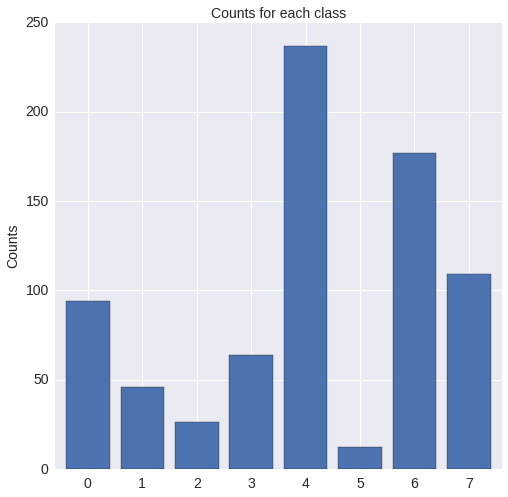

In [38]:
# 2**3 selectivity classes

def selclass(label1, label2, label3):
    return label3 + 2 * label2 + 4 *label1

panel['selclass'] = pd.DataFrame(map(selclass, panel['F10'], panel['trypsin'], panel['thrombin']))
grouped = panel.groupby('selclass').count()

params = {'legend.fontsize': 14,
          'figure.figsize': (8, 8),
         'axes.labelsize': 14,
         'axes.titlesize': 14,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}

plt.rcParams.update(params)

plt.bar(grouped.index, grouped['reference'], align = 'center')
plt.ylabel('Counts')
plt.title('Counts for each class')
plt.xlim(-0.6, 7.6)

#show class labels
df = panel.groupby("selclass", group_keys = "false").sum()
df[df != 0] = 1
df

## Compute Morgan 2 fingerprints (Rdkit) and convert fingerprints to numpy array ##

In [7]:
def compute_morgan2(Smiles):
    mol = Chem.MolFromSmiles(Smiles)
    if mol is None:
        return None
    return rdmd.GetMorganFingerprintAsBitVect(mol, 2, 2048)

panel['morgan2'] = panel['smiles'].map(compute_morgan2)

In [8]:
def maptonumpy(x):
    arr = np.zeros(len(x))
    DataStructs.ConvertToNumpyArray(x, arr)
    return arr

panel['np_morgan2'] = panel['morgan2'].map(maptonumpy)
panel.dropna(subset=['morgan2'], inplace=True)

## Sort publications (reference) according to number of molecules described in each publication. ##

In [9]:
top_n = 20 # select the top 20 publications (ranking according to molecules count per publication)

references = pd.DataFrame(panel.groupby(['reference'])['reference'].count())
del references.index.name
print "===================================================================="
print "The first %s publications provide data for %s molecules out of %s." %(top_n, references.sort_values(by='reference', ascending=False).head(top_n)['reference'].sum(), panel.shape[0])
print "===================================================================="

The first 20 publications provide data for 414 molecules out of 765.


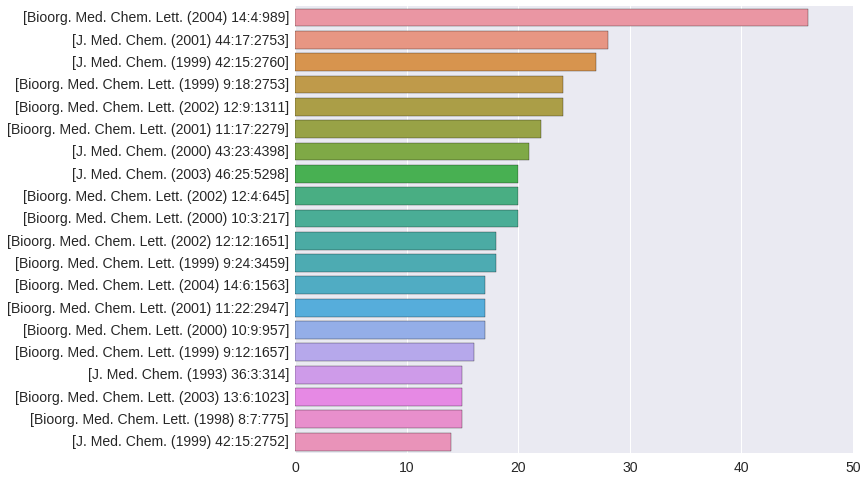

In [10]:
ref = references.sort_values(by='reference', ascending=False)['reference']
ref_n = references.sort_values(by='reference', ascending=False).head(top_n)['reference']

plt.figure(figsize=(10, 8))
sns.barplot(x=ref_n.values, y=ref_n.index, orient="h")

### Molecules described in top 20 publications are combined to create a literature cluster. ###

## Divide into training and test data-set based on literature cluster. ##

In [11]:
train =  panel[panel['reference'].isin(ref_n.index.tolist())==True]   #DataFrame.isin returns a boolean dataframe with True for a match
test = panel[panel['reference'].isin(ref_n.index.tolist())==False]

X_train = train['np_morgan2'].tolist()
X_test = test['np_morgan2'].tolist()

In [12]:
#lists for single-output (so) classifier
targets = panel.columns[2:5].tolist()

Y_train=[]
Y_test=[]

for i in range(len(targets)):
    Y_train.append(train[targets[i]].tolist())
    Y_test.append(test[targets[i]].tolist())

In [13]:
#tuples for multi-output (mo) classifier
Y_train_mo = zip(Y_train[0], Y_train[1], Y_train[2])
Y_test_mo = zip(Y_test[0], Y_test[1], Y_test[2])

## Divide into training and test data-set using stratified 2-fold and random shuffling. ##

In [14]:
X =  panel['np_morgan2'].tolist()
  
Y_3D = panel[targets]

Y_list=[]

for i in range(len(targets)):
    Y_list.append(panel[targets[i]].tolist())
        
skf_list = []
for i in range(len(targets)):
    skf_list.append(StratifiedKFold(Y_list[i], 2, shuffle=True))

# Training of the random forest classifier and assessment of estimator performance. #

We have performed an exhaustive search to obtain the best parameters for the random forest classifier.
The best parameters were determined separately by using GridSearch for each fold and each target.

The parameter search space is defined as:

'max_depth':[10,20],'min_samples_split':[2,8],'min_samples_leaf':[2,5],'n_estimators':[20,50,100]

## Training and testing on literature cluster ##

In [15]:
#train random forest classifier on multi-output (mo), perform parameter search for each fold and target

params = {'max_depth':[10,20],'min_samples_split':[2,8],'min_samples_leaf':[2,5],'n_estimators':[20,50,100]}

precision_mo_list = []; recall_mo_list = []
fpr_mo_list = []; tpr_mo_list = []
roc_mo_auc_list = []; proba_mo_list = []

for i in range(len(targets)):
    #switch training and test set
    for j in [0, 1]:
        if j == 0:
            x_train, y_train = np.array(X_train), np.array(Y_train_mo)
            x_test, y_test = np.array(X_test), np.array(Y_test_mo)[:, i]
        else:
            x_train, y_train = np.array(X_test), np.array(Y_test_mo)
            x_test, y_test = np.array(X_train), np.array(Y_train_mo)[:, i]

        cv = StratifiedKFold(y_train[:, i],n_folds=10,shuffle=True)
        gs = GridSearchCV(RandomForestClassifier(), params, cv=cv,verbose=0,refit=True)
        gs.fit(x_train, y_train)
        clf_rf = gs.best_estimator_
        # print gs.best_params_

        proba_mo = clf_rf.predict_proba(x_test)[i][:, -1]
        precision, recall, thresholds = precision_recall_curve(y_test, proba_mo)
        fpr, tpr, threshold = roc_curve(y_test, proba_mo)
        roc_auc = roc_auc_score(y_test, proba_mo)

        precision_mo_list.append(precision); recall_mo_list.append(recall)
        fpr_mo_list.append(fpr); tpr_mo_list.append(tpr)
        roc_mo_auc_list.append(roc_auc); proba_mo_list.append(proba_mo)

In [16]:
#train random forest classifier on single-output (so)
precision_list = []; recall_list = []
fpr_list = []; tpr_list = []
roc_auc_list = []; prob_list = []


for i in range(len(targets)):
    #switch training and test set
    for j in [0, 1]:
        if j == 0:
            x_train, y_train = np.array(X_train), np.array(Y_train[i])
            x_test, y_test = np.array(X_test), np.array(Y_test[i])
        else:
            x_train, y_train = np.array(X_test),  np.array(Y_test[i])
            x_test, y_test = np.array(X_train), np.array(Y_train[i])

        cv = StratifiedKFold(y_train,n_folds=10,shuffle=True)
        gs = GridSearchCV(RandomForestClassifier(), params, cv=cv,verbose=0,refit=True)
        gs.fit(x_train, y_train)
        clf_rf = gs.best_estimator_
        # print gs.best_params_

        proba_1D = [p[1] for p in clf_rf.predict_proba(x_test).tolist()]
        precision, recall, thresholds = precision_recall_curve(y_test, proba_1D)
        fpr, tpr, threshold = roc_curve(y_test, proba_1D)
        roc_auc = roc_auc_score(y_test, proba_1D)

        precision_list.append(precision); recall_list.append(recall)
        fpr_list.append(fpr); tpr_list.append(tpr)
        prob_list.append(proba_1D); roc_auc_list.append(roc_auc)

In [17]:
# helper functions to plot precission versus recall and ROC curves

def plot_prec(precision, recall, targets, label, colors =['r', 'g', 'b']):
    """plot precission and recall for target in targets 
    and for each fold"""
    for i in range(len(targets)):  
        fold_1 = plt.plot(recall[2*i], precision[2*i], label='fold 1: %s' % targets[i])
        fold_2 = plt.plot(recall[2*i+1], precision[2*i+1], '--', label='fold 2: %s' % targets[i])   
        plt.setp(fold_1, color=colors[i])
        plt.setp(fold_2, color=colors[i])
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(label)
    plt.legend(loc="lower left")
    plt.plot()
    
def plot_proc(fpr, tpr, roc, targets, label, colors = ['r', 'g', 'b']):
    """plot ROC for target in targets 
    and for each fold"""
    for i in range(len(targets)):    
        fold_1 = plt.plot(fpr[2*i], tpr[2*i], label='fold 1: %s area = %0.4f' % (targets[i], roc[2*i]))
        fold_2 = plt.plot(fpr[2*i+1], tpr[2*i+1], '--', label='fold 2: %s area = %0.4f' % (targets[i], roc[2*i+1]))   
        plt.setp(fold_1, color=colors[i])
        plt.setp(fold_2, color=colors[i])
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.title(label)
    plt.legend(loc="lower right")

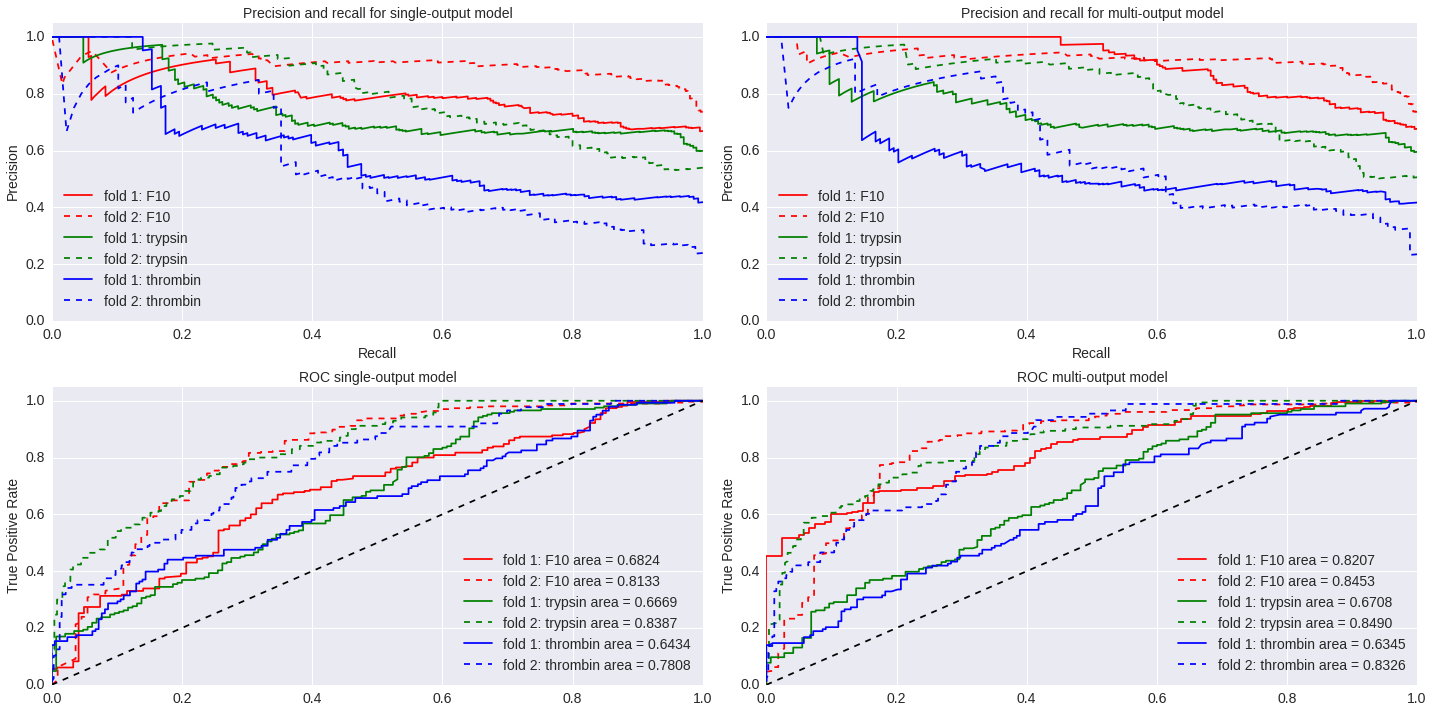

In [18]:
plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
fig_lc_pr_so = plot_prec(precision_list, recall_list, targets, 'Precision and recall for single-output model')
plt.subplot(2, 2, 2)
fig_lc_pr_mo = plot_prec(precision_mo_list, recall_mo_list, targets, 'Precision and recall for multi-output model')

plt.subplot(2, 2, 3)
fig_lc_roc_so = plot_proc(fpr_list, tpr_list, roc_auc_list, targets, 'ROC single-output model')
plt.subplot(2, 2, 4)
fig_lc_roc_mo = plot_proc(fpr_mo_list, tpr_mo_list, roc_mo_auc_list, targets, 'ROC multi-output model')

plt.tight_layout()

Classifier performance varies strongly between the two folds. Also, a classifier trained on fold-2 and tested on fold-1 appears to perform better than vice versa. This behavior is consistent for all three targets, single output as well as multi output classification. 

Fold-1 consists of molecules from the first 20 publications and fold-2 of molecules from the remaining 104 publications. Molecules described in a given publication are often from the same family. Molecules from fold-1 are therefore from a smaller set of families than molecules contained in fold-2. This gives a possible explanation for the observation that the explorative power of a model build on fold-1 is limited.

## Training and testing on stratified 2-fold (random selection). ##

In [19]:
#SO classifier on training/test for each protease

precision_list = []; recall_list = []
fpr_list = []; tpr_list = []
roc_auc_list = []; prob_list = []

for i in range(len(targets)):
    for train, test in skf_list[i]:
        x_train= np.array(X)[train]; y_train = np.array(Y_list[i])[train]
        x_test= np.array(X)[test]; y_test = np.array(Y_list[i])[test]
        
        cv = StratifiedKFold(y_train,n_folds=10,shuffle=True)
        gs = GridSearchCV(RandomForestClassifier(), params, cv=cv,verbose=0,refit=True)
        gs.fit(x_train, y_train)
        clf_rf = gs.best_estimator_
        # print gs.best_params_
        
        proba_1D = [p[1] for p in clf_rf.predict_proba(x_test).tolist()]
        precision, recall, thresholds = precision_recall_curve(y_test, proba_1D)
        fpr, tpr, threshold = roc_curve(y_test, proba_1D)
        roc_auc = roc_auc_score(y_test, proba_1D)
        
        precision_list.append(precision); recall_list.append(recall)
        fpr_list.append(fpr); tpr_list.append(tpr)
        prob_list.append(proba_1D); roc_auc_list.append(roc_auc)

In [20]:
#MO classifier on training/test for each protease

precision_mo_list = []; recall_mo_list = []
fpr_mo_list = []; tpr_mo_list = []
roc_mo_auc_list = []; proba_mo_list = []


for i in range(len(targets)):
    for train, test in skf_list[0]:
        x_train= np.array(X)[train]; y_train = np.array(Y_3D)[:,0:3][train]
        x_test= np.array(X)[test]; y_test = np.array(Y_3D)[:,0:3][test]
        
        #clf_rf.fit(x_train, y_train)
        #cv = KFold(n=len(x_train),n_folds=10,shuffle=True)
        cv = StratifiedKFold(y_train[:, i],n_folds=10,shuffle=True)
        gs = GridSearchCV(RandomForestClassifier(), params, cv=cv,verbose=0,refit=True)
        gs.fit(x_train, y_train)
        clf_rf = gs.best_estimator_
        # print gs.best_params_
        
        proba_mo = clf_rf.predict_proba(x_test)[i][:,-1]
        precision, recall, thresholds = precision_recall_curve(y_test[:,i], proba_mo)
        fpr, tpr, threshold = roc_curve(y_test[:,i], proba_mo)
        roc_auc = roc_auc_score(y_test[:,i], proba_mo)
        
        precision_mo_list.append(precision); recall_mo_list.append(recall)
        fpr_mo_list.append(fpr); tpr_mo_list.append(tpr)
        roc_mo_auc_list.append(roc_auc); proba_mo_list.append(proba_mo)

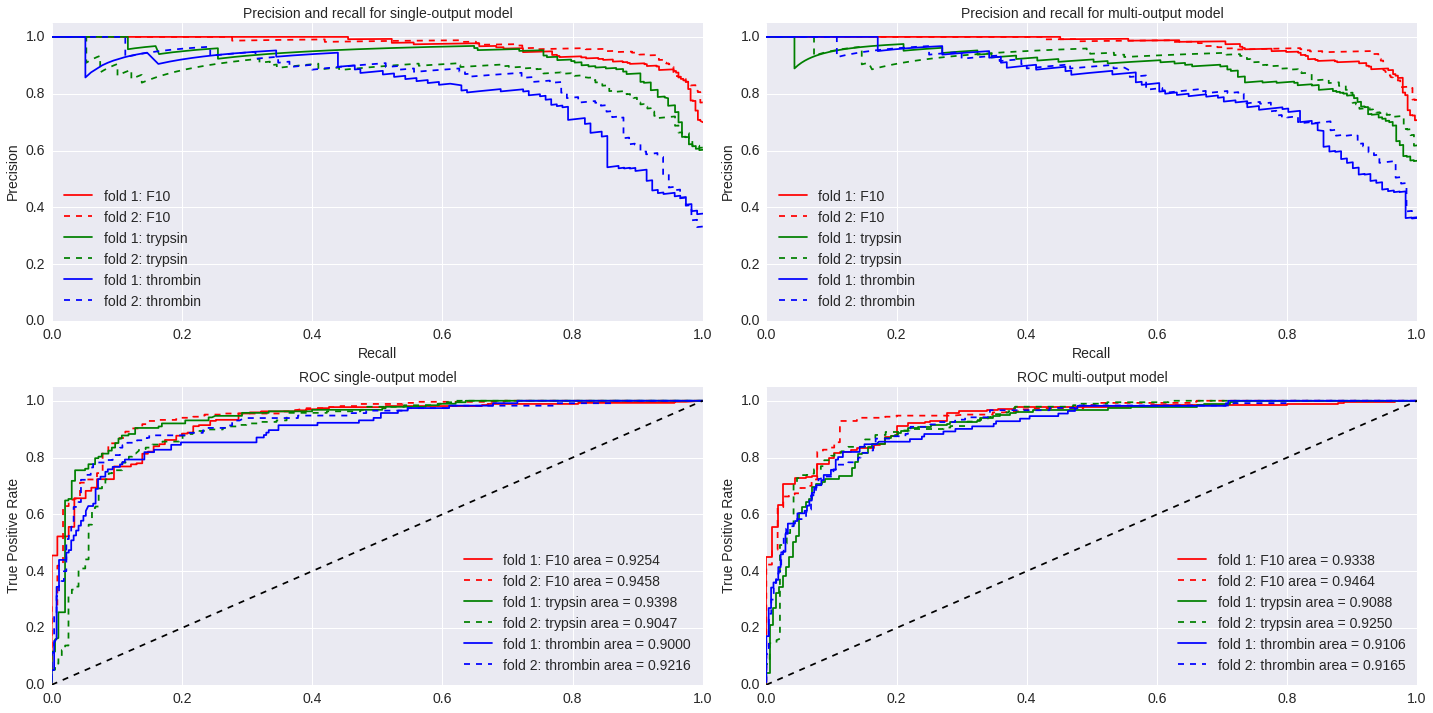

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plot1 = plot_prec(precision_list, recall_list, targets, 'Precision and recall for single-output model')
plt.subplot(2, 2, 2)
plot2 = plot_prec(precision_mo_list, recall_mo_list, targets, 'Precision and recall for multi-output model')

plt.subplot(2, 2, 3)
plot_proc(fpr_list, tpr_list, roc_auc_list, targets, 'ROC single-output model')
plt.subplot(2, 2, 4)
plot_proc(fpr_mo_list, tpr_mo_list, roc_mo_auc_list, targets, 'ROC multi-output model')

plt.tight_layout()

Precision, recall and the ROC area are improved by random partitioning and both folds show similar performance. The random split exhibits a much more consistent behavior across the splits than the literature cluster partitioning. Due to the random split, molecules from the same family are contained in both the training and the test set. This leads to an overestimation of the extrapolative power of the models built on random partitions. 

# Selectivity maps: a visualization of selectivity  contributions#
## Visualize atom contributions to selectivity on molecular drawing ##

#### Based on Similarity Maps: ####
Riniker, S. & Landrum, G. A. "Similarity maps - a visualization strategy for molecular fingerprints and machine-learning methods." *Journal of Cheminformatics* **5:43** (2013).

### Probability for selectivity on target 1 defined as: ###

$ {p}_{sel}(t_1) \equiv {p}_{active}(t_1) * {p}_{inactive}(t_2) * {p}_{inactive}(t_3) $

${p}_{inactive}() = 1 - {p}_{active}()$

${p}_{active}(t_1)$ ... probability for active on target 1, predicted by multi output random forest classifier

### Visualization of selectivity. ###

The "weight" of an atom is defined as the difference:

${p}_{sel}(t_1)$(base) - ${p}_{sel}(t_1)$(bits of the corresponding atom removed) 

The weights are then used to color the atoms in a topography-like map with green indicating a positive difference (contribute to selectivity) and pink indicate a negative difference.

In [22]:
#encode image
from io import BytesIO
from base64 import b64encode

def img_func(x):
   b = BytesIO()
   x.savefig(b, format='png', dpi=70, bbox_inches='tight')
   return '<img alt="2d array" src="data:image/png;base64,' + b64encode(b.getvalue()) + '"/>'

In [23]:
#show similarity maps for one molecules
tomol = lambda x: Chem.MolFromSmiles(x)
mols_subset = map(tomol, panel['smiles'][0:1])
chemblID_subset = panel['parent__cmpd__chemblid'][0:1]
references_subset =  panel['reference'][0:1]

In [24]:
#nested lists for encoded images for SimilarityMaps
#clone (deepcopy) of estimator does not preserve fitting parameters: therefore classifier needs to be refitted for each training set

imgs = [[], [], []]

x_train = [np.array(X)[train], np.array(X_train), np.array(X_test)]
y_train = [np.array(Y_3D)[:,0:3][train], np.array(Y_train_mo), np.array(Y_test_mo)]

target_nr = 0 # show maps for F10

for i in range(len(x_train)):
    cv = StratifiedKFold(y_train[i][:, target_nr],n_folds=10,shuffle=True)
    gs = GridSearchCV(RandomForestClassifier(), params, cv=cv,verbose=0,refit=True)
    gs.fit(x_train[i], y_train[i])
    clf_rf = gs.best_estimator_
    
    for m in mols_subset:
        fp = lambda m,i: SimilarityMaps.GetMorganFingerprint(m, i, nBits=2048)
        fig, maxweight =  maps.GetSimilarityMapForModel(m, fp, lambda x: maps.getProbaprod(x, clf_rf.predict_log_proba, target_nr=target_nr), size=(180, 180), weightsScaling=False)
        imgs[i].append(img_func(fig))
        plt.close(fig)

trained on stratified 2-fold,trained on top 20 publications,trained on remaining publications,chembl_id,reference
,,,CHEMBL100067,[Bioorg. Med. Chem. Lett. (2001) 11:22:2947]

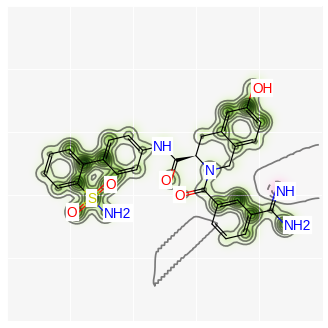
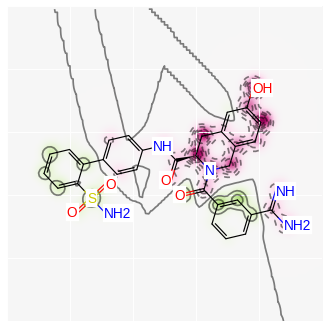
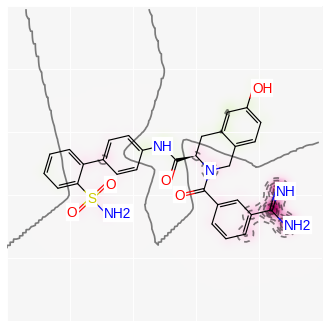

In [25]:
s = """<table width=1200>
<tr>
   <th>trained on stratified 2-fold</th> 
   <th>trained on top 20 publications</th> 
   <th>trained on remaining publications</th>
   <th>chembl_id</th>
   <th>reference</th>
</tr>"""

for i in range(len(imgs[0])):
    s = s + """
    <tr>
       <th>%s</th>
       <th>%s</th>
       <th>%s</th>
       <th>%s</th>
       <th>%s</th>
    </tr>"""%(imgs[0][i], imgs[1][i], imgs[2][i], chemblID_subset[i], references_subset[i])
s = s + """
</table>"""

t=HTML(s)
t

link to CHEMBL100067: 
<https://www.ebi.ac.uk/chembl/compound/inspect/CHEMBL100067>